In [1]:
from gwdetectors import *
from Functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
# Define network, detector, signal

c = 299792458.0 # m/s

K_instantiator, K_loc, K_arms = DETECTOR_ORIENTATIONS['K']
kagra = K_instantiator('Kagra', PSDS[KNOWN_PSDS[0]], K_loc, K_arms, long_wavelength_approximation=False)

CE_loc = np.array([-1000, 4000, 4000]) * 1000 / 299792458 # somewhere in Asia
CE_arms = DETECTORS['CE@L_ce-design'].arms
CE_psd = DETECTORS['CE@L_ce-design'].psd
CE = TwoArmDetector('CE', CE_psd, CE_loc, CE_arms, long_wavelength_approximation=False)

network = Network(DETECTORS['H_aligo-design'], DETECTORS['L_aligo-design'], 
                  DETECTORS['V_advirgo-design'], kagra, CE)

fsr = 1 / (2 * np.sum(CE_arms[0]**2)**0.5)

# Pick shape of sine-Gaussian signal pulse
a = fsr # frequency of sinusoidal component 
A = 1e-23 # Gaussian peak amplitude
c = 1e-3 # standard deviation of Gaussian envelope
dt= 0
p = 0

numpts=200
spread=4

freqs, ast_signal = produce_freqs_signal(numpts, spread, a, A, c, dt, p)

info = {'a': a, 'A': A, 'c': c, 'dt':dt, 'phi':p, 'network':network}

In [47]:
# Parameters for "true" data

az_true=0
po_true=0 

# Note: if az_true = 0 and po_true = 0, the HLVK match is very bad for the optimized strain coordinates (~0.007) 
# and the true coordinates (~0.4), and the overall match is bad for the optimized strain coordinates,
# and even worse for the true coordinates. But if az_true = 0 and po_true = pi/3, the HLVK match
# is quite bad for the optimized strain coordinates (~0.7), but much better for the true coordinates (~0.97), 
# and the overall match for the true coordinates is similarly much better than the optimized match. 
# Suggests that the grid spacing makes a massive difference. 

psi_true=0
geocent=0
true_keys=['hp']
coord = 'geographic'

true_modes = dict.fromkeys(true_keys, ast_signal)

data = network.project(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

true_snr = network.snr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)
snrs = network.testsnr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

true_params = {'pole': po_true, 'azim':az_true,
               'psi': psi_true, 'geocent':geocent, 'modes':true_keys
              }

In [48]:
# Create dictionary with true parameters to store results

current_dict = {}

In [49]:
# Calculates optimization over t0, psi, phi0 for a grid of sky locations

npts=20 # resolution for psi, t0 
ranges_slice = ((0, np.pi, np.pi/8), (dt-0.04, dt+0.04, 0.08/8), (0, 2*np.pi, 2*np.pi/8)) 
geocent=0
coord='geographic'
keys=['hb']

num=45 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:-1], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
missing_pairs = [(0, 0), (0, np.pi)]
Coords_flat = list(zip(Azimuths_flat, Poles_flat)) + missing_pairs

optimization_variables = [a, A, c, network, freqs, geocent, data, coord, keys]

In [50]:
# Optimization performed here
# Remember to change workers depending on number of CPU processes available

if __name__ == '__main__':
    list_results = main_cf(Coords_flat, 
                           filter_3, ranges_slice, npts,
                           optimization_variables, 
                           workers=32, 
                           finish=True)

In [51]:
# Reshaping results into a grid

reshaped = np.reshape(list_results[:-2], (num-1, num-2))
zero_zero = list_results[-2]
zero_pi = list_results[-1]
zero_pi_arr = np.full((num-1,), zero_pi)
zero_zero_arr = np.full((num-1,), zero_zero)
poles_added = np.column_stack((zero_pi_arr, reshaped, zero_zero_arr))
pi_x_arr = poles_added[-1,:]
azimuth_added = np.row_stack((pi_x_arr, poles_added))

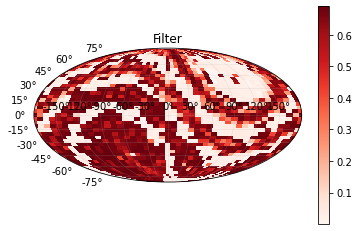

In [52]:
# Plot filter over sky locations

phi_plt = np.linspace(-np.pi, np.pi, num)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, azimuth_added, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

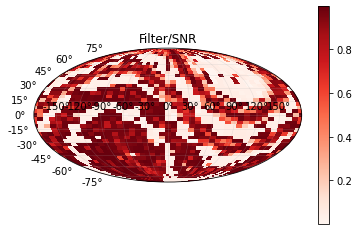

In [53]:
# Plot filter/true snr over sky

phi_plt = np.linspace(-np.pi, np.pi, num)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, azimuth_added/true_snr, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter/SNR')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

In [54]:
# Overall match resulting from optimization

max_filter = np.max(list_results)
rho_match = max_filter / true_snr

print(f"Max filter: {max_filter}")
print(f"Match: {rho_match}")

Max filter: 0.6902851432182519
Match: 0.9964852895168764


In [55]:
# Find sky parameters that correspond to optimization result

max_skyindex = np.where(list_results == np.max(list_results))
max_sky_coords = [Coords_flat[i] for i in max_skyindex[0]]
print(f'Max sky coords:{max_sky_coords}')
max_az, max_po = max_sky_coords[0]

[(1.1423973285781068, 0.7853981633974483)]


In [56]:
# Find parameters that give maximum filter response

if len(max_sky_coords) == 1: 
    max_vars = brute_max(filter_3, ranges_slice, npts, *optimization_variables, 
                         max_az, max_po, finish=True)[0]
else: 
    max_vars_all = [brute_max(filter_3, ranges_slice, npts, *optimization_variables, max_az, max_po, 
                              finish=True)[0] for max_az, max_po in max_sky_coords]
    max_vars = max_vars_all[0]

max_psi, max_t0, max_phi = max_vars
print(f"Max azim: {max_az}, max pole: {max_po}, max psi: {max_psi}, max t0:{max_t0}, max_phi: {max_phi}")

[1.96349541 0.00371126 1.55573485]
Max azim: 1.1423973285781068, max pole: 0.7853981633974483, max psi: 1.9634954084936207, max t0:0.003711263601823829, max_phi: 1.555734854813012


In [57]:
# test against true parameters, except polarization mode (azim, pole, psi, phi, t0)

test_mode = dict.fromkeys(keys, ast_signal)

strain = network.project(freqs, geocent, az_true, po_true, psi_true, coord=coord, **test_mode)
snrs = network.testsnr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

print(f'True SNR:{true_snr}')
print(f'SNRS:{snrs}')
print(f'Filters:{network.testfilter(freqs, data, strain)}')
filter=np.sum(np.array(network.testfilter(freqs, data, strain))**2) ** 0.5
print(f'Filter{filter.real}')
print(f'Match:{filter.real/true_snr}')
print(f'Parameters:{az_true, po_true, psi_true, 0, 0}')

True SNR:0.6927198529472735
SNRS:[0.03785027 0.02772547 0.00484577 0.003751   0.69110195]
Filters:[-0.02997767+2.30861842e-02j -0.02767573-1.65842842e-03j
  0.0048284 -4.09509257e-04j  0.00374132-2.69019980e-04j
 -0.17758872-6.60174154e-01j]
Filter0.17689235117484098
Match:0.2553591476009064
Parameters:(0, 0, 0, 0, 0)


In [58]:
# test against true sky coordinates to make sure the grid resolution is fine enough (azim, pole)

results=brute_max(filter_3, ranges_slice, npts, *optimization_variables, 
                  az_true, po_true, 
                  finish=True)
true_coords_match = results[1]/true_snr
printf(f'True coords match:{true_coords_match}')

true_coords_psi, true_coords_t0, true_coords_phi = results[0]

true_coords_signal = ft_sine_Gaussian(freqs, a, A, c, true_coords_t0, true_coords_phi)
test_mode = dict.fromkeys(keys, true_coords_signal)

det_filters= []
det_snrs = []

for i, det in enumerate(network.detectors):
    opt_strain = det.project(freqs, geocent, az_true, po_true, true_coords_psi, coord=coord, **test_mode)
    det_filter = det.filter(freqs, data[i], opt_strain).real
    det_snr = det.snr(freqs, data[i])
    det_filters.append(det_filter)
    det_snrs.append(det_snr)

print(f'Filters:{det_filters}')
print(f'SNRs: {det_snrs}')

HLVK_match = np.sqrt(np.sum(np.array(det_filters[:4])**2)) / np.sqrt(np.sum(np.array(det_snrs[:4])**2))
CE_match = np.sqrt(np.sum(np.array(det_filters[4])**2)) / np.sqrt(np.sum(np.array(det_snrs[4])**2))

print(f'HLVK match:{HLVK_match}')
print(f'CE match:{CE_match}')

0.9385257390825286
Filters:[-0.01735423037500597, 0.0053661883238315285, -0.0002757916521464221, -0.00025857616646783436, 0.6498814858714778]
SNRs: [0.03785027255613761, 0.02772546780602164, 0.004845768468430868, 0.003750998165313518, 0.6911019450923067]
HLVK match:0.3839822848476055
CE match:0.9403554576664903


In [27]:
# validate optimization result

optimized_signal = ft_sine_Gaussian(freqs, a, A, c, max_t0, max_phi)

test_mode = dict.fromkeys(keys, optimized_signal)

opt_strain = network.project(freqs, geocent, max_az, max_po, max_psi, coord=coord, **test_mode)
snrs = network.testsnr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

print(f'True SNR:{true_snr}')
print(f'SNRS:{snrs}')
print(f'Filters:{network.testfilter(freqs, data, opt_strain)}')
filter=np.sum(np.array(network.testfilter(freqs, data, opt_strain))**2) ** 0.5
print(f'Filter:{filter.real}')
print(f'Match:{filter.real/true_snr}')
print(f'Parameters:{max_az, max_po, max_psi, max_t0, max_phi}')

True SNR:0.646165108336868
SNRS:[0.02753839 0.04244686 0.03675418 0.01010141 0.64305236]
Filters:[-2.36512189e-02+1.37788570e-02j  3.99297278e-02+1.41958924e-02j
 -4.25843653e-06-7.14163879e-06j  2.41741312e-06-4.15346888e-06j
  6.43024903e-01-7.45509904e-04j]
Filter:0.6443935058962672
Match:0.9972582821050789
Parameters:(2.7131936553730034, 3.0701928205536615, 1.2475484399894485, -0.016473987153766537, 6.220556821676569)


In [59]:
# For best overall optimized match, calculates filters and SNRs for each detector in network separately

optimized_signal = ft_sine_Gaussian(freqs, a, A, c, max_t0, max_phi)
test_mode = dict.fromkeys(keys, optimized_signal)

det_filters= []
det_snrs = []

for i, det in enumerate(network.detectors):
    opt_strain = det.project(freqs, geocent, max_az, max_po, max_psi, coord=coord, **test_mode)
    det_filter = det.filter(freqs, data[i], opt_strain).real
    det_snr = det.snr(freqs, data[i])
    det_filters.append(det_filter)
    det_snrs.append(det_snr)

print(f'Filters:{det_filters}')
print(f'SNRs: {det_snrs}')

HLVK_match = np.sqrt(np.sum(np.array(det_filters[:4])**2)) / np.sqrt(np.sum(np.array(det_snrs[:4])**2))
CE_match = np.sqrt(np.sum(np.array(det_filters[4])**2)) / np.sqrt(np.sum(np.array(det_snrs[4])**2))

print(f'HLVK match:{HLVK_match}')
print(f'CE match:{CE_match}')

overall_match = np.sqrt(np.sum(np.array(det_filters)**2)) / np.sqrt(np.sum(np.array(det_snrs)**2))
print(f'overall match:{overall_match}')

Filters:[-1.4340735365015681e-06, 8.412627591609066e-07, 0.0003120660815450018, -5.109961275110867e-06, -0.690285072657469]
SNRs: [0.03785027255613761, 0.02772546780602164, 0.004845768468430868, 0.003750998165313518, 0.6911019450923067]
HLVK match:0.006596202347984398
CE match:0.9988180145626292
overall match:0.9964852895168764


In [ ]:
# save parameters
run_results = {'match': rho_match, 
               'pole': max_po, 'azim':max_az,
               'psi': max_psi, 
               'phi':max_phi
              }

current_dict["_".join(keys)] = run_results

In [ ]:
# save filter grid array
np.savetxt(f"results/{true_keys}_{"_".join(keys)}.txt", filter_grid)

## Final results

In [ ]:
# Convert parameter dictionaries into dataframe

df_info = pd.DataFrame.from_dict(info)
df_trueparams = pd.DataFrame.from_dict(true_params)

In [ ]:
# Convert results dictionary into dataframe

df_results = pd.DataFrame.from_dict(current_dict)

In [ ]:
# Store final results for a set of true parameters

import os

run_name = 'detectors_match'

folder_path = f'./results/{run_name}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

df_info.to_csv(f'results/{run_name}/{"_".join(true_keys)}_info.csv')
df_trueparams.to_csv(f'results/{run_name}/{"_".join(true_keys)}_trueparams.csv')
df_results.to_csv(f'results/{run_name}/{"_".join(true_keys) +"-" + "_".join(keys)}.csv')

## Test individual detectors

In [ ]:
test_dict={}

num=45 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
Coords_flat = list(zip(Azimuths_flat, Poles_flat))

if __name__=='__main__':
    for i, detector in enumerate(network.detectors):
        optimization_variables = [a, A, c, detector, freqs, geocent, data[i], coord, keys]
        true_snr = detector.snr(freqs, data[i])
        list_results = main_cf(Coords_flat, 
                              filter_3_det, ranges_slice, npts,
                              optimization_variables, workers=64, finish=True)
        filter_grid=np.reshape(list_results, (num-1,num-1))
        max_filter = np.max(filter_grid)
        rho_match = max_filter / true_snr

        max_skyindex = np.where(filter_grid == np.max(filter_grid))
        max_skyindex_coords = list(zip(max_skyindex[0], max_skyindex[1])) # repacking into coordinate indexes
        max_sky_coords = [(azimuths[1:][azim_index], poles[1:][pole_index]) 
                          for (azim_index, pole_index) in max_skyindex_coords]
        max_az, max_po = max_sky_coords[0]

        if len(max_sky_coords) == 1: 
            max_vars = brute_max(filter_3_det, ranges_slice, npts, 
                                 *optimization_variables, max_az, max_po, finish=True)[0]
        else: 
            max_vars = [brute_max(filter_3_det, ranges_slice, npts, 
                                  *optimization_variables, 
                                  max_az, max_po, finish=True) for max_az, max_po in max_sky_coords]

        results = {'max_filter':max_filter, 'match':rho_match, 'max sky coords':max_sky_coords, 'max_vars':max_vars}
        test_dict[f'{i}'] = results

In [ ]:
df_test_dict = pd.DataFrame.from_dict(test_dict)

In [ ]:
df_test_dict.to_csv(f'results/{run_name}/{"_".join(true_keys)}_detectors.csv')